In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import pathlib

PROJECT_ROOT = pathlib.Path().cwd().parent
sys.path.append(str(PROJECT_ROOT))

image_path = PROJECT_ROOT / 'ReMIND2Reg_dataset' / 'imagesTr'

from src.utils import *
from src.impedance import *
from src.datatype import MRIDataset
from src.renderer import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans

c:\Users\noe\anaconda3\envs\torchIO\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
patient_id = "005" # between 000 and 102, t1 and t2 don't exist for all patients
iUS_file = f"ReMIND2Reg_0{patient_id}_0000.nii.gz"
t1_file = f"ReMIND2Reg_0{patient_id}_0001.nii.gz"
t2_file = f"ReMIND2Reg_0{patient_id}_0002.nii.gz"
# dataset = MRIDataset([image_path / t1_file], "T1", axis=0)

In [4]:
dataset = MRIDataset([image_path / t1_file, image_path / t2_file], "T1", axis=0)

In [5]:
dataset2 = MRIDataset([PROJECT_ROOT / "structures.nii.gz"], "CT", axis=0)

FileNotFoundError: File not found: "c:\Users\noe\Desktop\MIT\6.8300\project\DiffUS_DifferentiableUltrasoundfromMRI\structures.nii.gz"

In [ ]:
T1 = dataset[0]
T1_volume = T1["image"].squeeze(0)       # (D,H,W)
T2 = dataset[1]
T2_volume = T2["image"].squeeze(0)       # (D,H,W)

In [6]:
CT = dataset2[0]
CT_volume = CT["image"].squeeze(0)       # (D,H,W)

NameError: name 'dataset2' is not defined

In [127]:
T1_volume = T1_volume.float()

t1 = np.array([-2.0, -1.0, 0.0,  1.5]).reshape(-1,1)
t2 = np.array([-2.0, -0.5, 0.0,  2.0]).reshape(-1,1)
z1 = np.array([400,  1.52e6, 1.7e6, 1.38e6]).reshape(-1,1)/1e6
z2 = np.array([400,  1.38e6, 1.7e6, 1.52e6]).reshape(-1,1)/1e6

X1 = torch.tensor(t1, dtype=torch.float32)
Y1 = torch.tensor(z1, dtype=torch.float32)
X2 = torch.tensor(t2, dtype=torch.float32)
Y2 = torch.tensor(z2, dtype=torch.float32)

model_t1 = ImpedanceEstimator.train_model(X1, Y1, input_dim=1)
model_t2 = ImpedanceEstimator.train_model(X2, Y2, input_dim=1)

Z_vol = ImpedanceEstimator.compute_impedance_volume(T1_volume, model_t1, threshold=50)

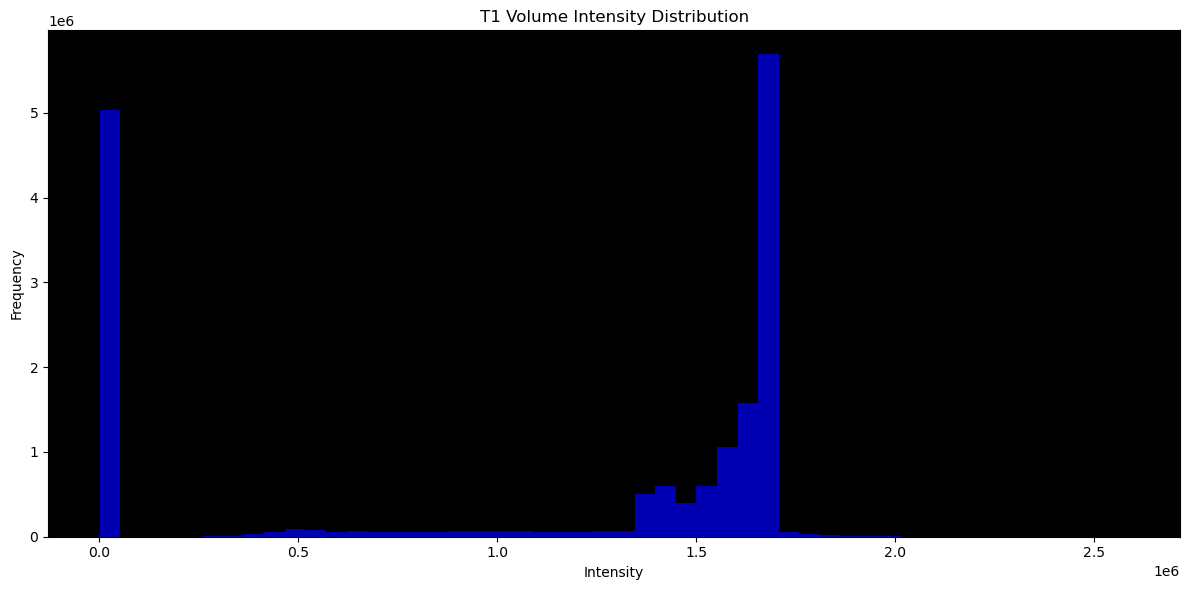

In [128]:
plot_histogram(Z_vol)

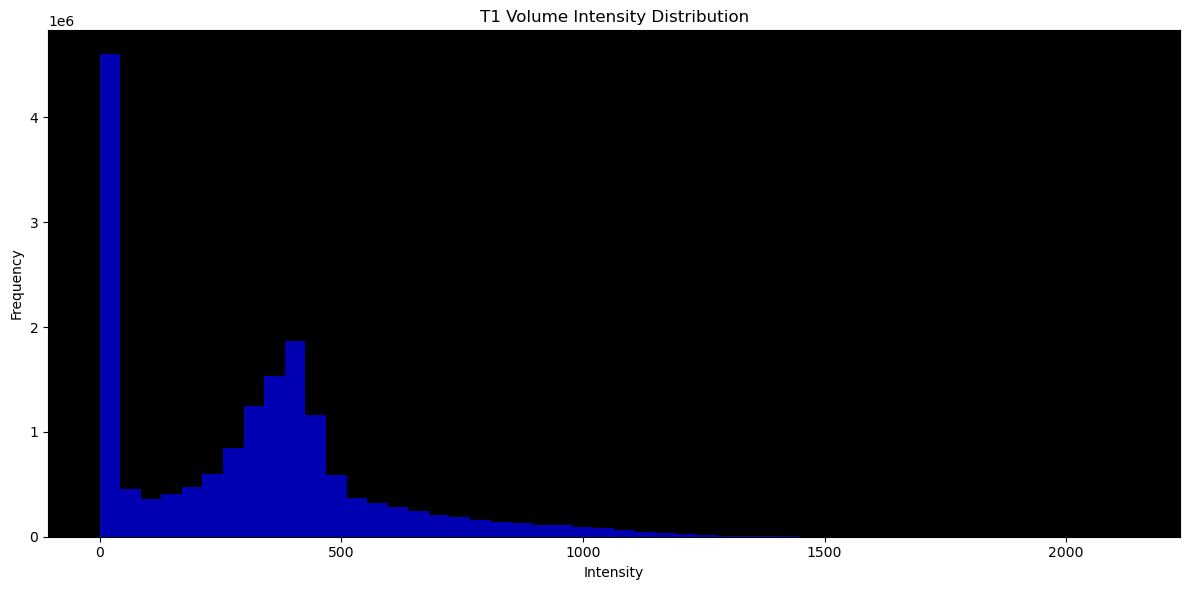

In [129]:
plot_histogram(T1_volume)

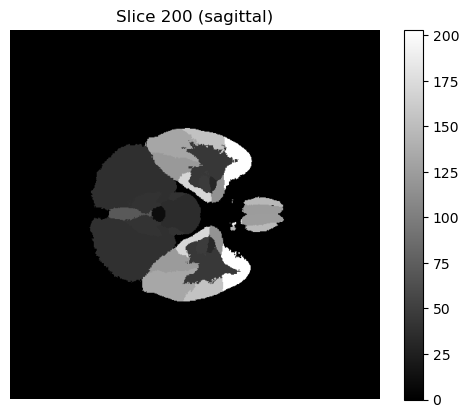

In [147]:
slice_id = 200
axis = 2  # 0: axial, 1: coronal, 2: sagittal

if axis == 0:
    img = CT_volume[slice_id, :, :]
elif axis == 1:
    img = CT_volume[:, slice_id, :]
elif axis == 2:
    img = CT_volume[:, :, slice_id]
else:
    raise ValueError("Axis must be 0 (axial), 1 (coronal), or 2 (sagittal).")

orientation = {0: 'axial', 1: 'coronal', 2: 'sagittal'}.get(axis, 'unknown')

plt.imshow(img.numpy(), cmap='gray')
plt.title(f"Slice {slice_id} ({orientation})")
plt.axis("off")
plt.colorbar()
plt.show()

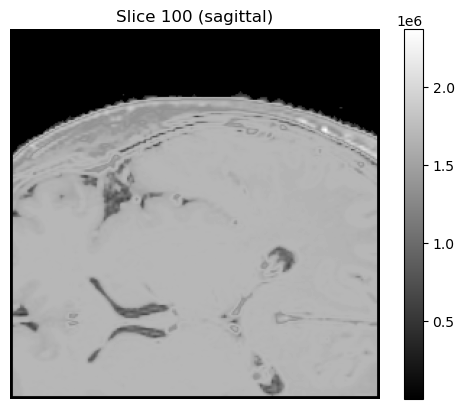

In [150]:
slice_id = 100
axis = 2  # 0: axial, 1: coronal, 2: sagittal

if axis == 0:
    img = Z_vol[slice_id, :, :]
elif axis == 1:
    img = Z_vol[:, slice_id, :]
elif axis == 2:
    img = Z_vol[:, :, slice_id]
else:
    raise ValueError("Axis must be 0 (axial), 1 (coronal), or 2 (sagittal).")

orientation = {0: 'axial', 1: 'coronal', 2: 'sagittal'}.get(axis, 'unknown')

plt.imshow(img.numpy(), cmap='gray')
plt.title(f"Slice {slice_id} ({orientation})")
plt.axis("off")
plt.colorbar()
plt.show()

In [131]:
UR = UltrasoundRenderer(400, 0.0001)

angle = 20  # degrees
rays = 200

thetas = np.radians(np.linspace(-angle,angle, rays))  # 64 rays across the fan
directions = [np.array([np.sin(theta), 0, np.cos(theta)]) for theta in thetas]

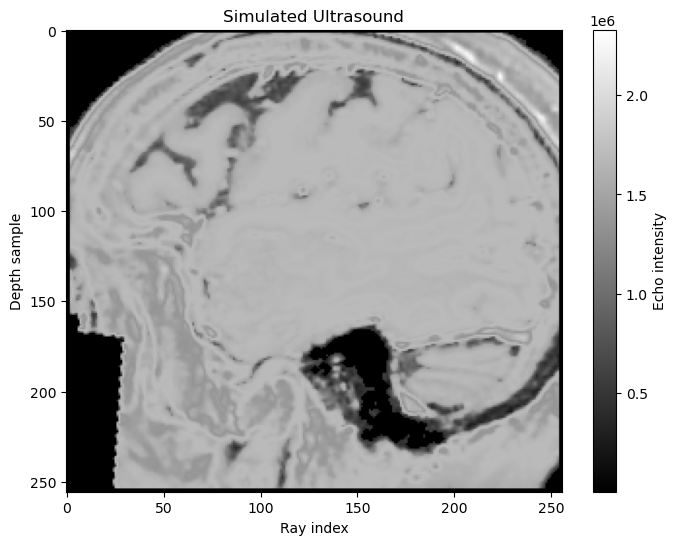

In [135]:
UR.plot_frame(
    Z_vol[100,:,:]
)

Processing rays: 100%|██████████| 200/200 [00:12<00:00, 15.82it/s]


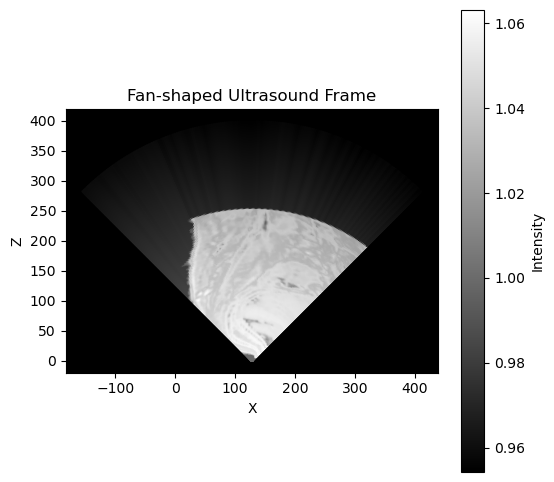

In [154]:
output = UR.plot_beam_frame(
    volume=Z_vol,
    source=torch.tensor([100,50.,0]),
    directions=torch.tensor(directions),
    angle=45
)

# output = UR.plot_beam_frame(
#     volume=T1_volume,
#     source=torch.tensor([100,40.,0]),
#     directions=torch.tensor(directions),
#     angle=45
# )

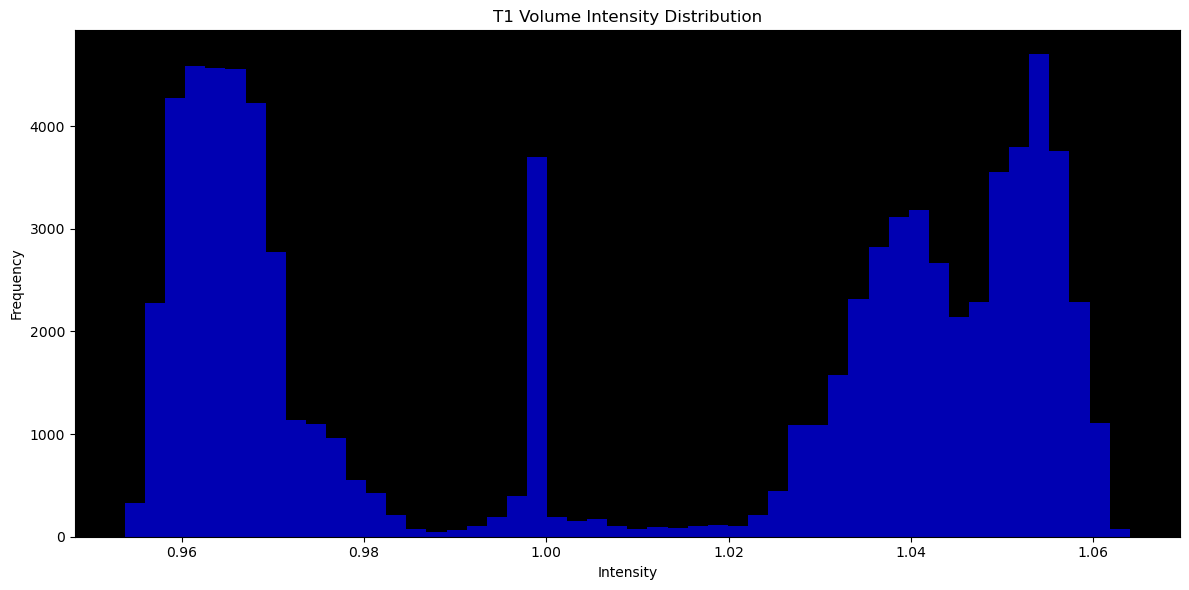

In [134]:
plot_histogram(output)